In [1]:
import kagglehub
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

scaler = MinMaxScaler()

# get dataset
path = kagglehub.dataset_download("hassan06/nslkdd")
print("Path to dataset files:", path)

train_name, test_name = 'KDDTrain+.arff', 'KDDTest+.arff'

Path to dataset files: /home/joao/.cache/kagglehub/datasets/hassan06/nslkdd/versions/1


In [2]:
# couldn't get arff loading libaries to work, so I'll do it manually
def parse_arff(p):
    with open(p, 'r') as f:
        lines = f.readlines()

        attribute_strings = [l.replace('\n', '').replace('@attribute ', '') for l in lines if l.startswith('@attribute')]

        attributes = {}
        for s in attribute_strings:
            # we only have attribute type real or categorical in this dataset
            att_name = s[0:s.find(' ')].replace('\'', '')
            if s.endswith('real'):
                attributes[att_name] = 'real'
            else:
                attributes[att_name] = eval(s[s.find(' ')+1:])

        data_ind = -1 # data starts at this index
        for i in range(len(lines)):
            if lines[i].find('@data') != -1:
                data_ind = i+1
        
        data = [] 
        positional_attribs = list(attributes.items()) # python 3.7+ guarantees dict order of insertion
        for d in lines[data_ind:]:
            attribs = d.replace('\n', '').split(',')
            row = []
            for i in range(len(attribs)):
                if positional_attribs[i][1] == 'real' or str(positional_attribs[i][1]) == '{\'0\', \'1\'}':
                    row.append(float(attribs[i]))
                else:
                    row.append(str(attribs[i]))
            data.append(row)

    return attributes, data

In [3]:
attributes, train_data = parse_arff(path+'/'+train_name)

train_data_df = pd.DataFrame(train_data, columns=list(attributes.keys()))

# exclude anomalous entries for encoder training
train_data_df = train_data_df[train_data_df['class'] == 'normal']
train_data_df = train_data_df.drop(columns=['class'])

# one hot encode categorical data
train_data_df['service'] = pd.Categorical(train_data_df['service'], categories=attributes['service'])
train_data_df['flag'] = pd.Categorical(train_data_df['flag'], categories=attributes['flag'])
train_data_df = pd.get_dummies(train_data_df, columns=['protocol_type', 'service', 'flag'])

#train_data_df

In [4]:
# before normalizing, let's see if we don't have any huge outliers since we're doing minmax scaling
# we can exclude our hot encoded ones, and also ignore any of the rate features or booleans
columns = list(train_data_df.columns)
excluded_indexes = [i for i in range(columns.index('protocol_type_icmp'), len(columns))]

train_data_np = train_data_df.to_numpy()
for i in range(len(columns)):
    if i not in excluded_indexes:
        col = train_data_np[:, i]
        std = col.std()
        if std != 0 and columns[i].find('rate') == -1 and columns[i].find('is_') == -1: 
            z_col = col/std
            z_col = z_col[(z_col > 6) | (z_col < -6)] # count entries that are beyond 6 z-score range
            print(f'for column {i} ({columns[i]}) std is {std:.2f}:', len(z_col))
            print(f'\t z-score of 6 corresponds to {std*6:.2f}')
    
            # automatically filter from out dataframe
            train_data_df = train_data_df[train_data_df[columns[i]] <= std*6]
        
# investigate by plotting our samples
#plt.scatter(np.linspace(0, 100000, len(train_data_df['duration'])), train_data_df['duration'], s=1)

# maybe log transform some of the fields that have 0 or large values
train_data_df['duration'] = np.log(train_data_df['duration']+0.001)
train_data_df['src_bytes'] = np.log(train_data_df['src_bytes']+0.001)
train_data_df['dst_bytes'] = np.log(train_data_df['dst_bytes']+0.001)

for column 0 (duration) std is 1304.44: 545
	 z-score of 6 corresponds to 7826.65
for column 1 (src_bytes) std is 418110.03: 16
	 z-score of 6 corresponds to 2508660.18
for column 2 (dst_bytes) std is 65462.33: 71
	 z-score of 6 corresponds to 392773.99
for column 3 (land) std is 0.01: 7
	 z-score of 6 corresponds to 0.06
for column 5 (urgent) std is 0.02: 6
	 z-score of 6 corresponds to 0.10
for column 6 (hot) std is 2.31: 520
	 z-score of 6 corresponds to 13.85
for column 7 (num_failed_logins) std is 0.05: 68
	 z-score of 6 corresponds to 0.30
for column 8 (logged_in) std is 0.45: 0
	 z-score of 6 corresponds to 2.72
for column 9 (num_compromised) std is 32.74: 43
	 z-score of 6 corresponds to 196.46
for column 10 (root_shell) std is 0.05: 137
	 z-score of 6 corresponds to 0.27
for column 11 (su_attempted) std is 0.06: 79
	 z-score of 6 corresponds to 0.37
for column 12 (num_root) std is 33.37: 45
	 z-score of 6 corresponds to 200.21
for column 13 (num_file_creations) std is 0.65: 81

In [5]:
print(len(train_data_df))
train_data_df

65519


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_S0,flag_S1,flag_RSTOS0,flag_OTH,flag_SH,flag_RSTO,flag_RSTR,flag_SF,flag_S2
0,-6.907755,6.196446,-6.907755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,-6.907755,4.983613,-6.907755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
3,-6.907755,5.446742,9.006141,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,-6.907755,5.293310,6.040257,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,True,False
12,-6.907755,5.659486,7.719130,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125965,-6.907755,7.711102,5.899900,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,True,False
125967,-6.907755,5.883325,5.926929,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,True,False
125969,2.079567,4.653970,4.976741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
125970,-6.907755,7.710206,5.950645,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,False,False,False,False,False,False,False,False,True,False


In [6]:
# normalize
data = scaler.fit_transform(train_data_df)

In [7]:
# We'll use pytorch to implement our model
# source for architecture: https://pmc.ncbi.nlm.nih.gov/articles/PMC8272075/pdf/sensors-21-04294.pdf
# Apparently, it looks like different depth and hidden layer neuron numbers achieve very similar results on this dataset
# We'll go for a symmetric autoencoder with depth of 5 with 64 neurons on the first hidden layer (subsequent layers divide number of neurons by 2)
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, latent_dim),
            # torch.nn.ReLU() MAYBE?
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, input_dim),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


class SampleDataset(Dataset): # want this so I can use dataloader
    def __init__(self, data_matrix):
        self.data = torch.from_numpy(data_matrix).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, ind):
        return self.data[ind]
    

In [13]:
model = Autoencoder(data.shape[1], 3)

if torch.cuda.is_available():
    model = model.to('cuda')

#model.forward(torch.from_numpy(data[0]).float())

loss_fun = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

dataset = SampleDataset(data)
loader = DataLoader(dataset, shuffle=True, batch_size=64)

In [14]:
print(dataset[0])

tensor([0.0000, 0.6082, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0062, 0.0062, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.5882, 0.0980, 0.1700, 0.0300, 0.1700, 0.0000, 0.0000, 0.0000,
        0.0500, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [15]:
MAX_EPOCH = 20

loss_log = []
for e in range(MAX_EPOCH):
    print('AT EPOCH ' + str(e))
    loss_sum = 0
    count = 0
    for s in loader:
        count += 1
        if torch.cuda.is_available():
            s = s.to('cuda')
        
        output = model.forward(s)
        loss = loss_fun(output, s)
        loss_sum += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if count % 100 == 0:
            loss_log.append(loss_sum/count)
            print(loss_sum/count)

AT EPOCH 0
0.24031653448939325
0.22776384241878986
0.1874408857151866
0.1469528790935874
0.12148848837800325
0.10430685265300174
0.09195783603138158
0.08272845630766824
0.07552256415701575
0.06974134288355709
AT EPOCH 1
0.017258514072746037
0.01734172018710524
0.017247166621188324
0.017123852344229817
0.01708869778364897
0.017047648926575978
0.016930792961003523
0.016829136110609398
0.016748805321339103
0.01668443994410336
AT EPOCH 2
0.01614089298993349
0.015887559014372526
0.015622351358955105
0.015484385802410542
0.015322304330766201
0.01523466595603774
0.015111623040533491
0.015008240297902375
0.014857920128852129
0.014697314908728004
AT EPOCH 3
0.012787501877173781
0.012629493023268878
0.012452258526658018
0.012233073894167319
0.012011222933419049
0.011819901808630675
0.011610535587450224
0.011415485759498552
0.011219586383344398
0.011045305291190743
AT EPOCH 4
0.00884223723784089
0.008741689568851144
0.008679682317500314
0.00852140483330004
0.008363124991767109
0.00817772840770582

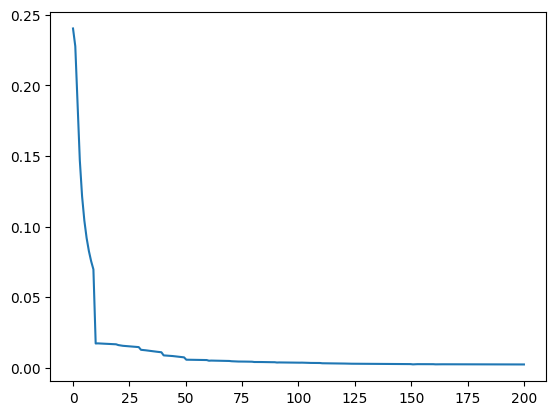

In [16]:
plt.plot(np.linspace(0, len(loss_log), len(loss_log)), loss_log)